# Share Price Predictor
### This solution predicts the next day share value using deep learning with RNN. The model is trained using the past one year share details using Yahoo API through Pandas DataReader library

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

#import for stock data visaulization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import for reading from yahoo fin
from pandas_datareader import data
from datetime import datetime

import tensorflow as tf

#### Download the past stock price data for 1 year using the Yahoo Data Reader

In [2]:
#define stocks to be used for data analysis
stock_list = ['WMT', 'AMZN', 'DE', 'GOOG']
#start and end date for fetching data. Get last 1 year history of stock price
end = datetime.now()
start = datetime(end.year-1, end.month, end.day)
#Using Yahoo API dowload the stock price history
for stock_symbol in stock_list:
    globals() [stock_symbol] = data.DataReader(stock_symbol, 'yahoo', start , end)

In [3]:
#view summary stocks of Walmart
print ('Walmart')
print(WMT.describe())
#view summary stocks of Amazon
print ('Amazon')
print(AMZN.describe())
print ('John Deere')
print(DE.describe())


Walmart
             High         Low        Open       Close        Volume  \
count  250.000000  250.000000  250.000000  250.000000  2.500000e+02   
mean    95.673960   94.225320   94.887560   94.962080  7.868656e+06   
std      5.628721    5.539734    5.624526    5.587032  3.600193e+06   
min     82.519997   81.809998   81.959999   82.400002  3.727800e+06   
25%     92.147501   90.257500   91.237501   91.207500  5.678200e+06   
50%     96.655003   95.225002   95.864998   95.880001  7.104000e+06   
75%     99.457500   98.027498   98.567501   98.705000  9.032425e+06   
max    106.209999  104.809998  105.500000  105.559998  4.263130e+07   

        Adj Close  
count  250.000000  
mean    93.725158  
std      5.931513  
min     80.615227  
25%     90.239994  
50%     94.539955  
75%     97.790514  
max    103.873398  
Amazon
              High          Low         Open        Close        Volume  \
count   250.000000   250.000000   250.000000   250.000000  2.500000e+02   
mean   1773.678

In [4]:
WMT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-05-29 to 2019-05-24
Data columns (total 6 columns):
High         250 non-null float64
Low          250 non-null float64
Open         250 non-null float64
Close        250 non-null float64
Volume       250 non-null float64
Adj Close    250 non-null float64
dtypes: float64(6)
memory usage: 13.7 KB


In [5]:
#create a pandas DataFrame for WMT stock
WMT_ds = pd.DataFrame(WMT['Adj Close'])

In [6]:
WMT_ds.shape

(250, 1)

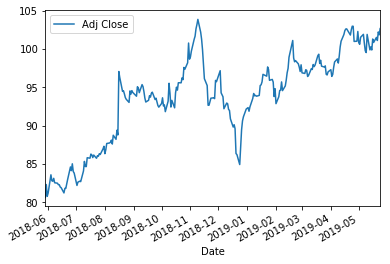

In [7]:
WMT_ds.plot()

In [8]:
WMT_arr = WMT_ds.iloc[:,0].values

In [9]:
WMT_arr.shape

(250,)

In [10]:
WMT_arr[0]

80.61522674560547

In [11]:
# divide the data into small batches and use them to train
def next_batch(batch_size,num_steps):
    x_batch = np.zeros((batch_size,num_steps))
    y_batch = np.zeros((batch_size,num_steps))
    
    for i in range(batch_size):
        stindex = np.random.randint(0,250-num_steps-1)
        #print(stindex)
        endindex = stindex + num_steps
        x_batch[i] = WMT_arr[stindex: stindex + num_steps]
        y_batch[i] = WMT_arr[stindex+1: stindex+num_steps+1]
    return x_batch, y_batch


In [12]:
x_batch, y_batch  = next_batch(10,20)

In [13]:
x_batch.shape, y_batch.shape

((10, 20), (10, 20))

In [14]:
x_batch[1]

array([84.06877136, 85.32103729, 84.65576935, 84.64598083, 85.80041504,
       85.74172211, 86.27981567, 86.16241455, 85.81999969, 86.15263367,
       85.73194122, 86.05479431, 85.99609375, 86.31895447, 86.22111511,
       86.9548645 , 87.29729462, 86.32872772, 86.83747101, 87.65927887])

In [15]:
y_batch[1]

array([85.32103729, 84.65576935, 84.64598083, 85.80041504, 85.74172211,
       86.27981567, 86.16241455, 85.81999969, 86.15263367, 85.73194122,
       86.05479431, 85.99609375, 86.31895447, 86.22111511, 86.9548645 ,
       87.29729462, 86.32872772, 86.83747101, 87.65927887, 87.72774506])

In [16]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

#### Deep Learning using Tensorflow
Find the share price 1 day ahead

In [17]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [ ]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [ ]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [ ]:
learning_rate = 0.001
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [ ]:
# save the trained model so that it can be used later
saver = tf.train.Saver()
n_iterations = 1000
batch_size = 15

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        X_batch = X_batch.reshape(batch_size,n_steps,1)
        y_batch = y_batch.reshape(batch_size,n_steps,1)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./share_predictor_model") # not shown in the content

In [ ]:
# restore the saved model
# pass the input to the model and get the prediction
with tf.Session() as sess:
    saver.restore(sess, "./share_predictor_model")

    X_new = WMT_arr[109:129]
    X_new = X_new.reshape(1,20,1)
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    y_true= WMT_arr[110:130]
    print(y_pred)

In [ ]:
plt.plot(y_true, marker="o", color="green")
plt.plot(y_pred.ravel(), marker="*", color="blue")

In [ ]:
#View First 5 records
WMT_ds.head()

In [ ]:
WMT_ds.plot(legend=True, figsize=(10,4))

In [ ]:
#view volume of stock traded every day
WMT['Volume'].plot(legend=True, figsize=(10,4))

In [ ]:
#plot all stock performances  on Adj close for entire year
plt.figure(figsize=(14,8))
plt.plot(WMT['Adj Close'], 'r', label='Walmart', linewidth=1)
plt.plot(AMZN['Adj Close'], 'b', label='Amazon', linewidth=1)
plt.plot(DE['Adj Close'], 'g', label='John Deere', linewidth=1)
plt.plot(GOOG['Adj Close'], 'm', label='Google', linewidth=1)
plt.legend()
plt.show()

In [ ]:
#computing pc chnage
WMT['Daily Return'] = WMT['Adj Close'].pct_change()
WMT['Daily Return'].plot(figsize=(15,6), legend=True, linestyle='--', marker='o')

In [ ]:
#Fetch closing prices
closing_price_stock = data.DataReader(['WMT', 'AMZN', 'DE', 'GOOG'], 'yahoo', start , end)['Adj Close']

In [ ]:
closing_price_stock.head()

In [ ]:
stock_returns = closing_price_stock.pct_change()

In [ ]:
#compare daily returns of Google and Walmart
sns.jointplot('GOOG', 'WMT', stock_returns,kind='scatter')

In [ ]:
sns.pairplot(stock_returns.dropna())